In [1]:
%load_ext autoreload
%autoreload 2

import os

import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack

from mrf.display import display_single, SEG_CMAP

plt.rcParams['text.usetex'] = True

### Implement `mrf` task by providing directories of input images, along with galaxies you want to retain during `mrf`.

In [17]:
from mrf.task import MrfTask
task = MrfTask('m101-df3.yaml')
img_lowres = 'M101_DF3_df_r.fits'
img_hires_b = 'M101_DF3_cfht_r.fits'
img_hires_r = 'M101_DF3_cfht_r.fits'
certain_gal_cat = 'gal_cat_m101.txt'
results = task.run(img_lowres, img_hires_b, img_hires_r, certain_gal_cat, 
                   output_name='m101_df3', verbose=True)

2019-10-27 22:04:42,191 Running Multi-Resolution Filtering (MRF) on "cfht" and "df" images!
2019-10-27 22:04:42,207 Magnify Dragonfly image with a factor of 3.0:
2019-10-27 22:04:42,453 Register high resolution image "M101_DF3_cfht_r.fits" with "M101_DF3_df_r.fits"
2019-10-27 22:04:43,875 Register high resolution image "M101_DF3_cfht_r.fits" with "M101_DF3_df_r.fits"
2019-10-27 22:04:45,167 Build flux models on high-resolution images: Blue band
2019-10-27 22:04:45,168     - sigma = 2.5, minarea = 2
2019-10-27 22:04:45,169     - deblend_cont = 0.00500, deblend_nthres = 32.0
2019-10-27 22:04:45,953     - Detect 7437 objects
2019-10-27 22:04:50,537 Build flux models on high-resolution images: Red band
2019-10-27 22:04:50,538     - sigma = 2.5, minarea = 2
2019-10-27 22:04:50,539     - deblend_cont = 0.00500, deblend_nthres = 32.0
2019-10-27 22:04:51,325     - Detect 7437 objects
2019-10-27 22:04:56,008 Make color correction to blue band, remove artifacts as well
2019-10-27 22:04:56,091   

### The results are stored in `results`. You can simply show the `mrf` results as follows. 

In [18]:
# Adjust mask size using the following function
from mrf.utils import adjust_mask

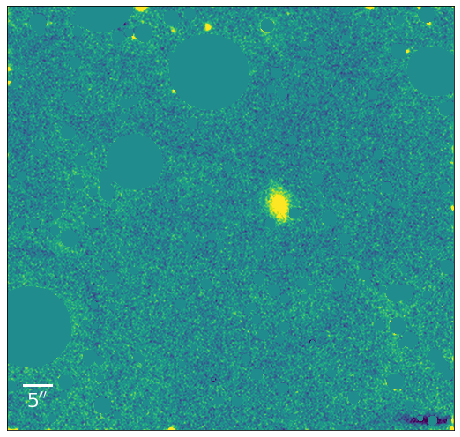

In [19]:
results = adjust_mask(results, gaussian_threshold=0.002, gaussian_radius=1.5, bright_lim=15, r=13)

In [20]:
# Calculate surface brightness contrast using the following function
from mrf.sbcontrast import cal_sbcontrast

In [22]:
cal_sbcontrast(results.lowres_final.image, results.lowres_mask.image, results.config.lowres.pixel_scale, 
               results.config.lowres.zeropoint, scale_arcsec=[10, 20, 30])

    - Surface brightness limit on 10 arcsec scale is 30.4918 +- 0.0136
    - Surface brightness limit on 20 arcsec scale is 31.0725 +- 0.0293
    - Surface brightness limit on 30 arcsec scale is 31.3017 +- 0.0454


array([[10.        , 20.        , 30.        ],
       [30.49177155, 31.07250091, 31.30171685]])

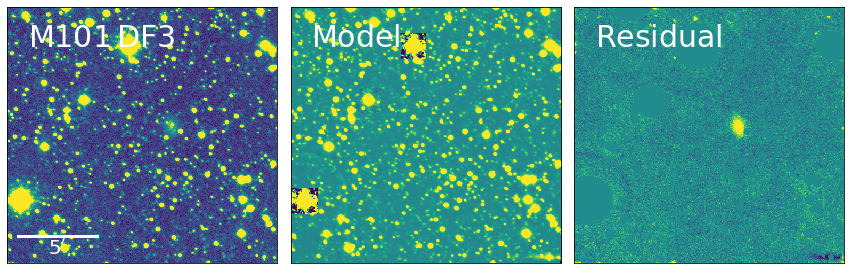

In [23]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 8))
ax1 = display_single(results.lowres_input.image, ax=ax1, pixel_scale=2.0, 
                     scale_bar_length=300, scale_bar_y_offset=0.3, add_text='M101\,DF3')
ax2 = display_single(results.lowres_model.image, ax=ax2, scale_bar=False, add_text='Model')
ax3 = display_single(results.lowres_final.image, ax=ax3, scale_bar=False, add_text='Residual')

plt.subplots_adjust(wspace=0.05)
#plt.savefig('m101-df3-demo.png', bbox_inches='tight')#, facecolor='silver')

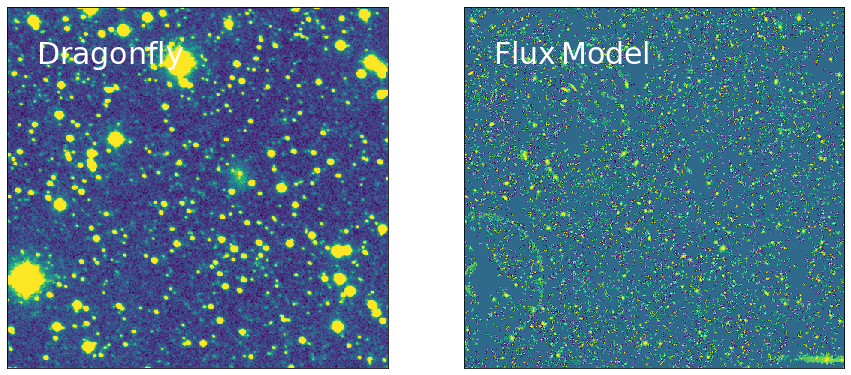

In [25]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 8))
ax1 = display_single(results.lowres_input.image, ax=ax1, 
                     scale_bar=False, add_text='Dragonfly')
ax2 = display_single(results.hires_fluxmod.image, ax=ax2, scale='percentile', lower_percentile=0.5,
                     scale_bar=False, add_text='Flux\,Model')
#plt.savefig('m101-df3-fluxmodel.png', bbox_inches='tight')

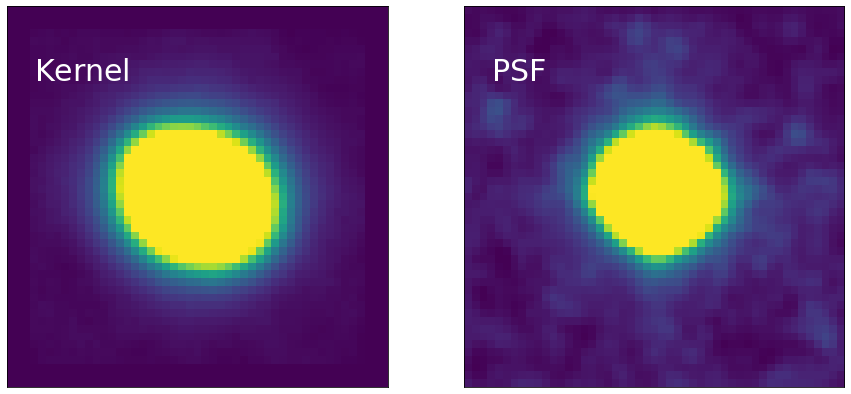

In [26]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 8))

ax1 = display_single(results.kernel_med, ax=ax1, 
                     scale_bar=False, add_text='Kernel')
ax2 = display_single(results.PSF, ax=ax2, 
                     scale_bar=False, add_text='PSF')
#plt.savefig('m101-df3-kernel-psf.png', bbox_inches='tight')

In [27]:
results.config.config

{'hires': {'dataset': 'cfht', 'zeropoint': 30.0, 'pixel_scale': 0.372},
 'lowres': {'dataset': 'df',
  'band': 'r',
  'pixel_scale': 2.0,
  'sub_bkgval': False,
  'magnify_factor': 3.0,
  'zeropoint': 20.0,
  'color_term': 0.0},
 'sex': {'sigma': 2.5,
  'minarea': 2,
  'b': 64,
  'f': 3,
  'deblend_cont': 0.005,
  'deblend_nthresh': 32,
  'sky_subtract': True,
  'flux_aper': [3, 6],
  'show_fig': False},
 'fluxmodel': {'gaussian_radius': 1.5,
  'gaussian_threshold': 0.05,
  'unmask_lowsb': False,
  'sb_lim': 25.0,
  'unmask_ratio': 3,
  'interp': 'iraf',
  'minarea': 25},
 'kernel': {'kernel_size': 8,
  'kernel_edge': 1,
  'nkernel': 25,
  'frac_maxflux': 0.1,
  'circularize': False,
  'show_fig': True},
 'starhalo': {'bright_lim': 17.5,
  'fwhm_lim': 200,
  'n_stack': 10,
  'halosize': 24,
  'padsize': 50,
  'edgesize': 5,
  'norm': 'flux_ann',
  'b': 32,
  'f': 3,
  'sigma': 3.5,
  'minarea': 3,
  'deblend_cont': 0.003,
  'deblend_nthresh': 32,
  'sky_subtract': True,
  'flux_aper': 